In [ ]:
using Pkg
Pkg.activate("Twitter")

In [ ]:
using Twitter, Graphs, GraphPlot, SparseArrays, LinearAlgebra

---
---
# Laden der Daten

Zunächst laden wir Daten von Twitter. 

dazu müssen wir uns zunächst authentifizieren.

Im Twitter [Developer Portal](https://developer.twitter.com/en) muss eine neue Application erstellt werden.

Dort können dann `CONSUMER_KEY`, `CONSUMER_SECRET`, `ACCESS_TOKEN` und `ACCESS_TOKEN_SECRET` generiert werden.

Siehe auch die [Dokumentation des Twitter.jl Packages](https://github.com/randyzwitch/Twitter.jl)



In [34]:
CONSUMER_KEY = ;
CONSUMER_SECRET = ;
ACCESS_TOKEN = ;
ACCESS_TOKEN_SECRET = ;

twitterauth(CONSUMER_KEY, CONSUMER_SECRET, ACCESS_TOKEN, ACCESS_TOKEN_SECRET);

Wir laden die letzten 200 Tweet, die das Wort `Osnabrück` enthalten.

In [6]:
tweets = get_search_tweets(q = "Osnabrück", count = 200);

Wir wollen die Hashtags in diesen Tweets analysieren. 

Dazu erstellen wir eine Listen von Listen. Die $i$-te Liste enthält die Hashtags im $i$-ten Tweet

In [7]:
T = tweets["statuses"]
hashtags = Vector{Vector{String}}()
for (i,t) in enumerate(T)
    push!(hashtags, Vector{String}())
    for entry in t.entities["hashtags"]
        push!(hashtags[i], entry["text"])
    end
end
filter!(x -> !isempty(x), hashtags)

108-element Vector{Vector{String}}:
 ["Bode"]
 ["KarlAmZug"]
 ["KarlAmZug"]
 ["Aushilfen"]
 ["noz", "osnabrück"]
 ["noz", "osnabrück"]
 ["noz", "osnabrück"]
 ["noz", "osnabrück"]
 ["Querdepp", "Querdenken", "Osnabrück", "os1903", "os2603"]
 ["noz", "osnabrück"]
 ["Bode"]
 ["art4peace", "KunstGenuss"]
 ["art4peace", "Friedensstadt", "Osnabrück"]
 ⋮
 ["Osnabrück"]
 ["art4peace", "Friedensstadt", "Osnabrück"]
 ["RB66", "Osnabrück", "Münster"]
 ["TAY4816"]
 ["Türkgücü"]
 ["immerblaugelb"]
 ["Osnabrück", "FrankFraune", "TobiSilberrücken"]
 ["VfL_Osnabrück", "BremerBrücke", "VfL1899"]
 ["art4peace", "Friedensstadt", "Osnabrück"]
 ["Corona", "Osnabrück"]
 ["Querdenker", "Osnabrück", "os1903", "os2603"]
 ["art4peace", "KunstGenuss"]

Außerdem erstellen wir das Array `unique_hashtags`, welches alle Hashtags einzeln listet.

In [8]:
all_hashtags = vcat(hashtags...)
unique_hashtags = unique(all_hashtags)

65-element Vector{String}:
 "Bode"
 "KarlAmZug"
 "Aushilfen"
 "noz"
 "osnabrück"
 "Querdepp"
 "Querdenken"
 "Osnabrück"
 "os1903"
 "os2603"
 "art4peace"
 "KunstGenuss"
 "Friedensstadt"
 ⋮
 "Diepholz"
 "NWBRB75Bielefeld"
 "RB66"
 "Münster"
 "TAY4816"
 "Türkgücü"
 "immerblaugelb"
 "FrankFraune"
 "TobiSilberrücken"
 "VfL_Osnabrück"
 "BremerBrücke"
 "VfL1899"

---
---
# Definition des Graphen

Aus den Daten erstellen wir ein Netzwerk.

Die Knoten im Graphen sind die Hashtags.

Wir definieren eine Kante zwischen zwei Knoten, falls die zwei Hashtags in einem gemeinsamen Tweet auftauchen.

Zuerst berechnen wir die Adjazenzmatrix.

In [12]:
n = length(unique_hashtags)
A = zeros(Int, n, n)

function edge(hᵢ, hⱼ)
    for h in hashtags
        if hᵢ in h && hⱼ in h
            return 1
        end
    end
    return 0
end
    
    
for i in 2:(n-1)
    hᵢ = unique_hashtags[i]
    for j in (i+1):n
        hⱼ = unique_hashtags[j]
        A[i,j] = edge(hᵢ, hⱼ)
    end
end    
A = sparse(max.(A, A'))

65×65 SparseMatrixCSC{Int64, Int64} with 176 stored entries:
⠀⠀⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠈⢠⡲⣶⡀⡀⠀⣀⡀⠀⠀⠀⠀⠀⡀⣀⣈⠀⠀⣀⠀⣀⡀⢁⢀⢀⢀⡀⠀⣀⠀⠀
⠀⠀⠘⠻⠊⡠⠄⠀⠁⠀⠀⠀⠀⠀⠀⠀⠈⠘⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠈⠀⠁⢠⡲⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠸⠁⠀⠀⠀⠊⡠⣤⠀⠀⠀⠀⠀⠈⠀⠀⠀⠀⣤⠄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠛⠊⠀⣀⣀⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⣮⡻⡇⠠⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠠⠀⠀⠀⠀⠀⠀⠀⠈⠉⡉⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⡀⢸⣂⠀⠀⠀⠂⠀⠀⠀⠀⠀⠀⠀⠊⠀⠀⠀⠤⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠘⠀⠀⠀⠀⠀⣤⠀⠀⠀⠀⠀⠀⠀⠃⠀⠀⠊⡠⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠸⠀⠀⠀⠀⠀⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠠⠂⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠁⢐⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡠⣄⠀⠀⠀⠀⠀⠀
⠀⠀⠀⢐⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⠀⠀⡀⠀⠀⠀⠀
⠀⠀⠀⠈⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠀⠀⠀⠀⠀
⠀⠀⠀⠘⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠊⡠⡄
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠉⠀

die Adjazenzmatrix `A` definiert den Graphen `G`.

In [13]:
G = Graphs.Graph(A)

{65, 88} undirected simple Int64 graph

---
---
# Visualisierung

Wir visualisieren den Graphen wie folgt.

Dabei plotten wir Labels nur für jene Knoten, die einene Grad größer als 3 haben.

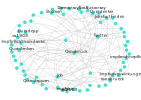

In [33]:
d = Graphs.degree(G)
c = findall(d .> 3)
labels = ["" for _ in 1:n]
labels[c] = unique_hashtags[c] 
layout= x -> spring_layout(x; C=30)
gplot(G, layout=layout, 
        linetype="curve", 
        nodelabel=labels,
        nodelabeldist=2
)

---
---
# Die Laplace Matrix

Wir berechnen die Laplace Matrix `L` von `G`.

In [16]:
L = zeros(n, n)
for i in 1:n
    for j in 1:n
        if i == j
            L[i,j] = 1
        elseif A[i,j] == 1
            L[i,j] = - 1 / sqrt(d[i] * d[j])
        end
    end
end
L

65×65 Matrix{Float64}:
 1.0  0.0  0.0   0.0       0.0      …   0.0        0.0   0.0   0.0
 0.0  1.0  0.0   0.0       0.0          0.0        0.0   0.0   0.0
 0.0  0.0  1.0   0.0       0.0          0.0        0.0   0.0   0.0
 0.0  0.0  0.0   1.0      -0.57735      0.0        0.0   0.0   0.0
 0.0  0.0  0.0  -0.57735   1.0          0.0        0.0   0.0   0.0
 0.0  0.0  0.0   0.0       0.0      …   0.0        0.0   0.0   0.0
 0.0  0.0  0.0   0.0       0.0          0.0        0.0   0.0   0.0
 0.0  0.0  0.0   0.0       0.0         -0.138675   0.0   0.0   0.0
 0.0  0.0  0.0   0.0       0.0          0.0        0.0   0.0   0.0
 0.0  0.0  0.0   0.0       0.0          0.0        0.0   0.0   0.0
 0.0  0.0  0.0   0.0       0.0      …   0.0        0.0   0.0   0.0
 0.0  0.0  0.0   0.0       0.0          0.0        0.0   0.0   0.0
 0.0  0.0  0.0   0.0       0.0          0.0        0.0   0.0   0.0
 ⋮                                  ⋱                         
 0.0  0.0  0.0   0.0       0.0          0.0

die Eigenwerte von `L` werden dann wie folgt berechnet:

In [17]:
E = eigen(L)
λ = E.values

65-element Vector{Float64}:
 -3.4674253908901645e-15
 -3.0446943235763185e-15
  6.661338147750939e-16
  9.492648167885393e-16
  0.06217380846964371
  0.128968836049137
  0.16345345546335843
  0.2879426609127027
  0.3159974525813498
  0.4149647000986718
  0.4999999999999993
  0.5000000000000001
  0.5015746944985779
  ⋮
  1.4999999999999998
  1.5
  1.5
  1.5
  1.5
  1.5
  1.5000000000000007
  1.5000000000000007
  1.5000000000000016
  1.5196388710582525
  1.7089305952093121
  1.8730858391428584

Die Summe der Eigenwerte ist gleich der Anzahl der Knoten.

In [18]:
sum(λ)

65.0

Ist `G` bipartit?

In [19]:
is_bipartite(G)

false

Wir analysieren einen Eigenvektor zum größten Eigenwert. 

In [20]:
v = E.vectors[:, n]
I = findall(abs.(v) .>  1e-14)
unique_hashtags[I]

38-element Vector{String}:
 "noz"
 "osnabrück"
 "Querdepp"
 "Querdenken"
 "Osnabrück"
 "os1903"
 "os2603"
 "art4peace"
 "KunstGenuss"
 "Friedensstadt"
 "Querdeppen"
 "SvenThore"
 "Job"
 ⋮
 "lkosnabrueck"
 "Corona"
 "QuerdenkerSindTerroristen"
 "Fahrrad"
 "Hamburg"
 "Bremen"
 "Tostedt"
 "Diepholz"
 "RB66"
 "Münster"
 "FrankFraune"
 "TobiSilberrücken"

Dieser eigenvektor definiert einen Untergraphen, der wie folgt aussieht:

In [21]:
H = Graphs.Graph(A[I,I])

{38, 66} undirected simple Int64 graph

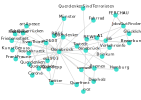

In [27]:
layout= x -> spring_layout(x; C=10)
gplot(H, layout = layout,
        nodelabel=unique_hashtags[I],
        nodelabeldist=2
)